In [ ]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from urllib.request import urlopen
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', None)

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/All_Amazon_Review_5.json.gz

--2021-11-02 05:26:40--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/All_Amazon_Review_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25270692239 (24G) [application/octet-stream]
Saving to: ‘All_Amazon_Review_5.json.gz’

All_Amazon_Review_5 100%[===================>]  23.54G  58.7MB/s    in 7m 32s  

2021-11-02 05:34:13 (53.3 MB/s) - ‘All_Amazon_Review_5.json.gz’ saved [25270692239/25270692239]



In [ ]:
# data = []
# with gzip.open('All_Amazon_Review_5.json.gz') as f:
#     counter = 0
#     for l in f:
#         #Using first 1M records. All records used up all the RAM. 
#         if counter == 1000000:
#           break
#         data.append(json.loads(l.strip()))
#         counter += 1
    
# # total length of list, this number equals total number of products
# print(len(data))

# # first row of the list
# print(data[0])

In [ ]:
# df = pd.DataFrame.from_dict(data)

# print(len(df))

In [ ]:
# df = df.dropna()
# print(len(df))

In [ ]:
# sentiment_df = pd.concat([df['unixReviewTime'], df['reviewText'], df['overall']], axis=1)
# sentiment_df['sentiment'] = np.where(sentiment_df['overall'] < 3, 'Negative', np.where(sentiment_df['overall'] > 3, 'Positive', 'Neutral'))
# sentiment_df.head()

In [ ]:
# labels = ['Positive', 'Neutral', 'Negative']
# counts = [0,0,0]

# counts[0] = len(sentiment_df.where(sentiment_df['sentiment'] == 'Positive').dropna())
# counts[1] = len(sentiment_df.where(sentiment_df['sentiment'] == 'Neutral').dropna())
# counts[2] = len(sentiment_df.where(sentiment_df['sentiment'] == 'Negative').dropna())

# print(counts)

In [ ]:
# plt.bar(labels, counts)
# plt.title('Sentiment Distribution')
# plt.xlabel('Sentiment')
# plt.ylabel('Number of Records')

In [ ]:
balanced_data = []
with gzip.open('All_Amazon_Review_5.json.gz') as f:
    pos_limit = 500000
    neg_limit = 500000
    for l in f:
        #Using first 1M records. All records used up all the RAM. 
        if pos_limit == 0 and neg_limit == 0:
          break
        json_data = json.loads(l.strip())
        overall = json_data['overall']
        if overall < 4.0 and neg_limit > 0: 
          balanced_data.append(json_data)
          neg_limit -= 1
        elif overall > 4.0 and pos_limit > 0:
          balanced_data.append(json_data)
          pos_limit -= 1
    
# total length of list, this number equals total number of products
print(len(balanced_data))

# first row of the list
print(balanced_data[0])
print(pos_limit,neg_limit)

1000000
{'overall': 2.0, 'verified': False, 'reviewTime': '12 5, 2015', 'reviewerID': 'A3KUPJ396OQF78', 'asin': 'B017O9P72A', 'reviewerName': 'Larry Russlin', 'reviewText': 'Can only control one of two bulbs from one of two echos', 'summary': 'Buggy', 'unixReviewTime': 1449273600}
0 0


In [ ]:
balanced_df = pd.DataFrame.from_dict(balanced_data)
b_sentiment_df = pd.concat([balanced_df['unixReviewTime'], balanced_df['reviewText'], balanced_df['overall']], axis=1)
b_sentiment_df['sentiment'] = np.where(b_sentiment_df['overall'] < 4.0, -1, 1)
b_sentiment_df.head()
b_sentiment_df.dtypes

unixReviewTime      int64
reviewText         object
overall           float64
sentiment           int64
dtype: object

In [ ]:
labels = ['Positive', 'Negative']
counts = [0, 0]

counts[0] = len(b_sentiment_df.where(b_sentiment_df['sentiment'] == 1).dropna())
counts[1] = len(b_sentiment_df.where(b_sentiment_df['sentiment'] == -1).dropna())

print(counts)
print(counts[0] + counts[1])

[499709, 499915]
999624


Text(0, 0.5, 'Number of Records')

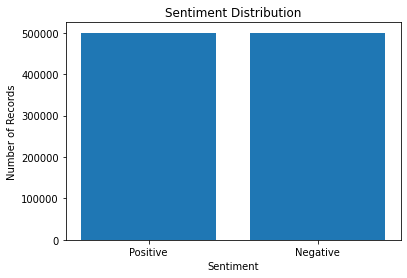

In [ ]:
plt.bar(labels, counts)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Records')

will use this balanced data set for training. 

In [ ]:
b_sentiment_df['datetimeReviewTime'] = pd.to_datetime(b_sentiment_df['unixReviewTime'], unit='s')
b_sentiment_df.head()

counts = {}

for i, x in b_sentiment_df.iterrows():
  year = x['datetimeReviewTime'].year

  if year not in counts:
    counts[year] = 1
  else:
    counts[year] += 1

In [ ]:
sorted_counts = {}

for i in sorted(counts.keys()):
  sorted_counts[i] = counts[i]
print(sorted_counts)

{1999: 2, 2000: 13, 2001: 82, 2002: 213, 2003: 299, 2004: 443, 2005: 821, 2006: 1280, 2007: 3803, 2008: 7116, 2009: 11595, 2010: 14706, 2011: 18730, 2012: 34404, 2013: 81727, 2014: 127800, 2015: 206084, 2016: 229584, 2017: 181477, 2018: 79821}


In [ ]:
print(list(sorted_counts.values()))



[2, 13, 82, 213, 299, 443, 821, 1280, 3803, 7116, 11595, 14706, 18730, 34404, 81727, 127800, 206084, 229584, 181477, 79821]


There is a good amount of data from 2012 to 2017. Will use this time range to validate issue

In [ ]:
b_sentiment_df = b_sentiment_df.set_index(['datetimeReviewTime'])
b_sentiment_df['reviewText'] = np.where(pd.isnull(b_sentiment_df['reviewText']), b_sentiment_df['reviewText'], b_sentiment_df['reviewText'].astype(str))

In [ ]:
df_13 = b_sentiment_df.loc['2013-01-01':'2014-01-01']
df_14 = b_sentiment_df.loc['2014-01-01':'2015-01-01']
df_15 = b_sentiment_df.loc['2015-01-01':'2016-01-01']
df_16 = b_sentiment_df.loc['2016-01-01':'2017-01-01']
df_17 = b_sentiment_df.loc['2017-01-01':'2018-01-01']
df_18 = b_sentiment_df.loc['2018-01-01':'2019-01-01']


sample_size = 40000

df_old = pd.concat([df_13.sample(sample_size), df_14.sample(sample_size)]).dropna()
df_new = pd.concat([df_15.sample(sample_size), df_16.sample(sample_size)]).dropna()
df_test = pd.concat([df_17.sample(sample_size), df_18.sample(sample_size)]).dropna()


The below section will attempt to recreate the issue seen in the Sentiment Analysis paper. Data from two time periods will be used to train two different models. This will then be analyzed against data from a third time period. The model closer in time to the test data should perform better. 

In [ ]:

old_text = df_old['reviewText']
new_text = df_new['reviewText']
test_text = df_test['reviewText']

all_text = pd.concat([old_text, new_text, test_text])

word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    analyzer='word',
    stop_words='english',
    ngram_range=(1, 1))

word_vectorizer.fit(all_text)

old_features = word_vectorizer.transform(old_text)
new_features = word_vectorizer.transform(new_text)
test_features = word_vectorizer.transform(test_text)



In [ ]:
old_model = LogisticRegression(random_state=12345, solver='liblinear')
old_model.fit(old_features, df_old['sentiment'])
predictions = old_model.predict(test_features)
old_model_accuracy = accuracy_score(df_test['sentiment'], predictions)
print(old_model_accuracy)


new_model = LogisticRegression(random_state=12345, solver='liblinear')
new_model.fit(new_features, df_new['sentiment'])
new_predictions = new_model.predict(test_features)
new_model_accuracy = accuracy_score(df_test['sentiment'], new_predictions)
print(new_model_accuracy)

0.8683687127078044
0.8792139399322016


The accuracy for the old model is lower than the new model. This is the same results as shown in the Sentiment Analysis paper. This is the problem we will be looking to solve by including time as a feature. 

What happens if we use the old model to predict all 4 future years? Does the accuracy decrease as we get farther from the training data?

In [ ]:
df_comb = pd.concat([df_15.sample(sample_size), df_16.sample(sample_size), df_17.sample(sample_size), df_18.sample(sample_size)]).dropna()
comb_text = df_comb['reviewText']
comb_features = word_vectorizer.transform(comb_text)
comb_predictions = old_model.predict(comb_features)


In [ ]:
year_correct = {'2015': 0, '2016': 0, '2017': 0, '2018': 0}
year_total = {'2015': 0, '2016': 0, '2017': 0, '2018': 0}

for i in range(len(comb_predictions)):
  
  if(comb_predictions[i] == df_comb['sentiment'][i]):
    year_correct[str(df_comb.index[i].year)] += 1
  
  year_total[str(df_comb.index[i].year)] += 1


print(year_correct)
print(year_total)

{'2015': 34988, '2016': 34870, '2017': 34904, '2018': 34756}
{'2015': 39883, '2016': 39962, '2017': 40016, '2018': 40045}


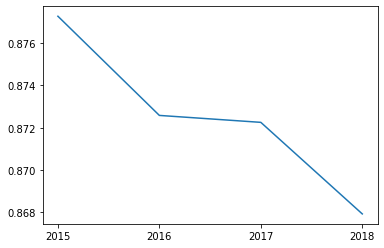

In [ ]:
year_accuracy = {}

for year in year_correct:
  year_accuracy[year] = year_correct[year] / year_total[year]

plt.plot(list(year_accuracy.keys()), list(year_accuracy.values()))
plt.show()

There is a general downward trend in the accuracy, although the difference is small, ranging from 0.874 to 0.868, approximately the 1.5% that was seen earlier


Lets see what happens if we train the model more traditionally, using an 80 / 20 split on all of the data

In [ ]:
df_total = pd.concat([df_13.sample(sample_size), df_14.sample(sample_size), df_15.sample(sample_size), df_16.sample(sample_size), df_17.sample(sample_size), df_18.sample(sample_size)]).dropna()

train_data, test_data, train_sentiment, test_sentiment = train_test_split(df_total.drop('sentiment', axis=1), df_total['sentiment'], test_size=0.2, random_state=12345)
print(train_data.shape)
print(train_sentiment.shape)
print(test_data.shape)
print(test_sentiment.shape)

train_features = word_vectorizer.transform(train_data['reviewText'])
test_features = word_vectorizer.transform(test_data['reviewText'])



(191926, 3)
(191926,)
(47982, 3)
(47982,)


In [ ]:
total_model = LogisticRegression(random_state=12345, solver='liblinear')
total_model.fit(train_features, train_sentiment)
total_predictions = total_model.predict(test_features)
total_model_accuracy = accuracy_score(test_sentiment, total_predictions)
print(total_model_accuracy)

0.8828727439456463


In [ ]:
print("Overall accuracy: " + str(total_model_accuracy))



year_correct = {'2013': 0, '2014': 0, '2015': 0, '2016': 0, '2017': 0, '2018': 0}
year_total = {'2013': 0, '2014': 0, '2015': 0, '2016': 0, '2017': 0, '2018': 0}

for i in range(len(total_predictions)):
  
  if(total_predictions[i] == test_sentiment[i]):
    year_correct[str(test_data.index[i].year)] += 1
  
  year_total[str(test_data.index[i].year)] += 1


Overall accuracy: 0.8828727439456463


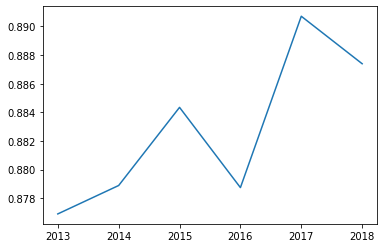

In [ ]:
year_accuracy = {}

for year in year_correct:
  year_accuracy[year] = year_correct[year] / year_total[year]

plt.plot(list(year_accuracy.keys()), list(year_accuracy.values()))
plt.show()

The accuracy is no longer dropping consistently over time, but it is not exactly stable either. Adding time as a feature should increase the overall accuracy and each year's accuracy. 

In [ ]:
train_data, test_data, train_sentiment, test_sentiment = train_test_split(df_total.drop('sentiment', axis=1), df_total['sentiment'], test_size=0.2, random_state=12345)
# print(train_data.shape)
# print(train_sentiment.shape)
# print(test_data.shape)
# print(test_sentiment.shape)

training_strings = []
test_strings = []

for i, x in train_data.iterrows(): 
  training_string = str(i.year) + ' ' +  x['reviewText']
  train_data.loc[i, 'text_with_year'] = training_string 

for i, x in test_data.iterrows(): 
  training_string = str(i.year) + ' ' +  x['reviewText']
  test_data.loc[i, 'text_with_year'] = training_string 


In [ ]:
# print(train_data.columns)
# print(train_data.head())
# print(test_data.head())

Index(['unixReviewTime', 'reviewText', 'overall'], dtype='object')
                    unixReviewTime  ... overall
datetimeReviewTime                  ...        
2015-10-22              1445472000  ...     5.0
2016-11-20              1479600000  ...     3.0
2018-02-13              1518480000  ...     5.0
2015-11-30              1448841600  ...     5.0
2015-01-12              1421020800  ...     5.0

[5 rows x 3 columns]
                    unixReviewTime  ...                                                                                                                                                                                               text_with_year
datetimeReviewTime                  ...                                                                                                                                                                                                             
2013-04-09              1365465600  ...                                              

In [ ]:
word_vectorizer_with_year = TfidfVectorizer(
    strip_accents='unicode',
    analyzer='word',
    stop_words='english',
    ngram_range=(1, 1))

all_text = pd.concat([train_data['text_with_year'], test_data['text_with_year']])

word_vectorizer_with_year.fit(all_text)

train_features = word_vectorizer_with_year.transform(train_data['text_with_year'])
test_features = word_vectorizer_with_year.transform(test_data['text_with_year'])

In [ ]:
year_model = LogisticRegression(random_state=12345, solver='liblinear')
year_model.fit(train_features, train_sentiment)
year_predictions = year_model.predict(test_features)
year_model_accuracy = accuracy_score(test_sentiment, year_predictions)
print(year_model_accuracy)

0.5181943228710767


accuracy is much lower. Need to look into why. 

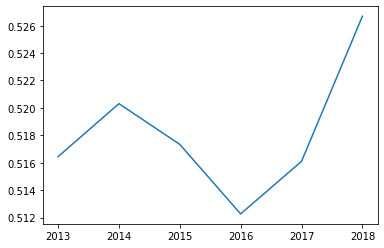

In [ ]:
year_correct = {'2013': 0, '2014': 0, '2015': 0, '2016': 0, '2017': 0, '2018': 0}
year_total = {'2013': 0, '2014': 0, '2015': 0, '2016': 0, '2017': 0, '2018': 0}

for i in range(len(year_predictions)):
  
  if(year_predictions[i] == test_sentiment[i]):
    year_correct[str(test_data.index[i].year)] += 1
  
  year_total[str(test_data.index[i].year)] += 1

year_accuracy = {}

for year in year_correct:
  year_accuracy[year] = year_correct[year] / year_total[year]

plt.plot(list(year_accuracy.keys()), list(year_accuracy.values()))
plt.show()

Shape is similar to model without year, with the exception of 2018. Perhaps works better with more data, or is simply overfitting. 


In [ ]:
train_predictions = year_model.predict(train_features)
train_accuracy = accuracy_score(train_sentiment, train_predictions)
print(train_accuracy)

0.5637641591029876


Even training accuracy is very low. Need to reevaluate approach or feed in more data. 